In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import MSTL

In [2]:
neft_data = pd.read_excel('D:\Personal\Education\PGDBA 2023-25\Sem1\SPA\TimeSeries Project\Payment Systems Volume Payment Transactions RBI Operated National Electronic Funds Transfer NEFT.xlsx')[:-7]

# Functions

In [3]:
def evaluate_stationarity(dataset):
    result = adfuller(dataset)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [4]:
neft_data['Date'] = neft_data['Date'].map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').strftime('%Y-%d-%m  00:00:00') if isinstance(x, str) else x)
neft_data['Date'] = pd.to_datetime(neft_data['Date'], format='%Y-%d-%m %H:%M:%S')
neft_data.rename(columns = {"Payment Volume (Unit mn)": "Volume"}, inplace = True)
print(neft_data)

           Date     Volume
0    2020-06-01  17.211000
1    2020-06-02  10.006772
2    2020-06-03  10.036426
3    2020-06-04   9.465655
4    2020-06-05  11.126259
...         ...        ...
1252 2023-11-05  11.863879
1253 2023-11-06  25.645393
1254 2023-11-07  30.939605
1255 2023-11-08  30.113271
1256 2023-11-09  28.903590

[1257 rows x 2 columns]


# EDA

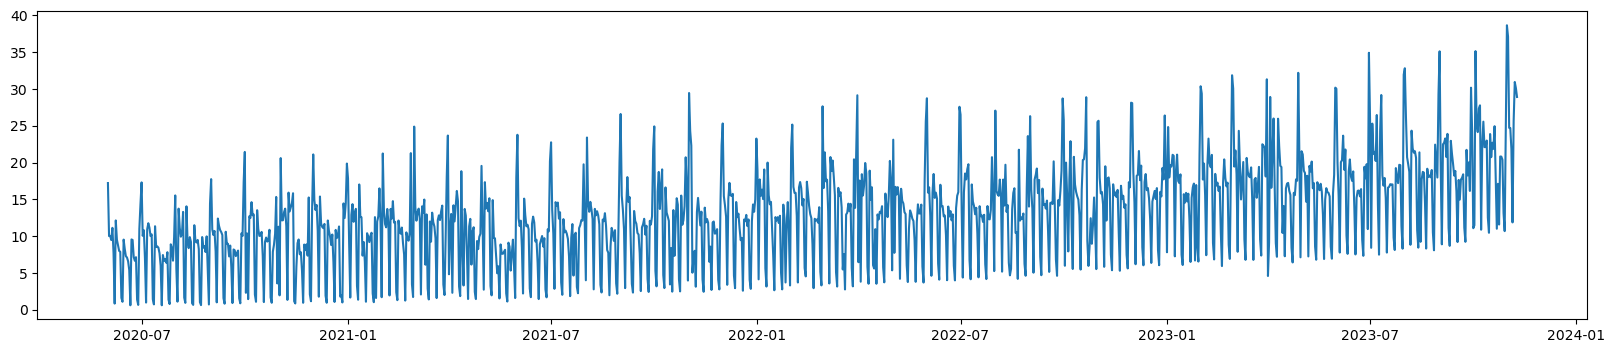

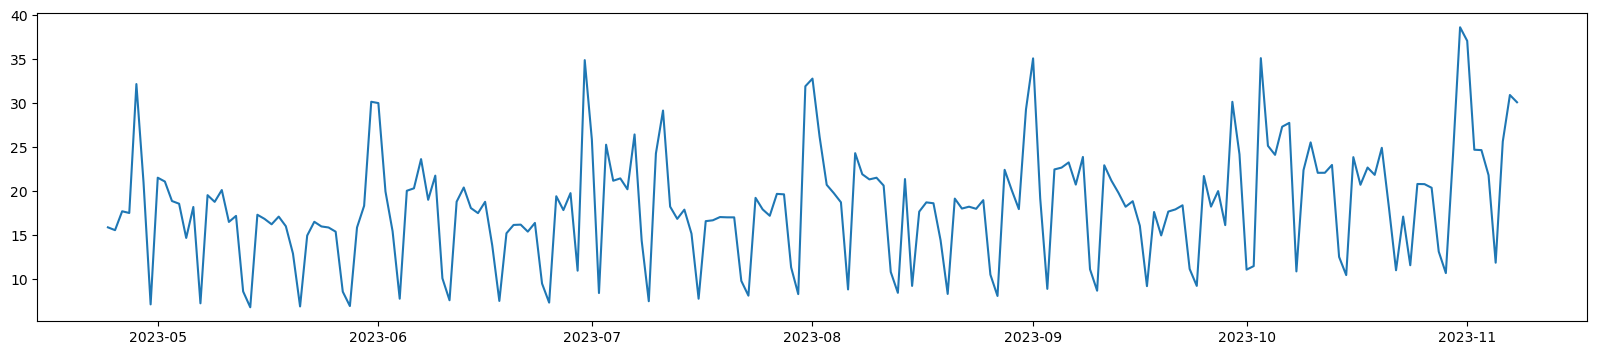

In [5]:
#Plot Entire Graph
plt.figure(figsize=(20,4))
plt.plot(neft_data['Date'], neft_data['Volume'])

#Plot A Sub-Section
plt.figure(figsize=(20,4))
neft_data_last_200 = neft_data[-200:-1]
plt.plot(neft_data_last_200['Date'], neft_data_last_200['Volume'])

In [6]:
#Train Test Split
neft_test = neft_data[-30:-1]
neft_train = neft_data[0:len(neft_data) - 30]

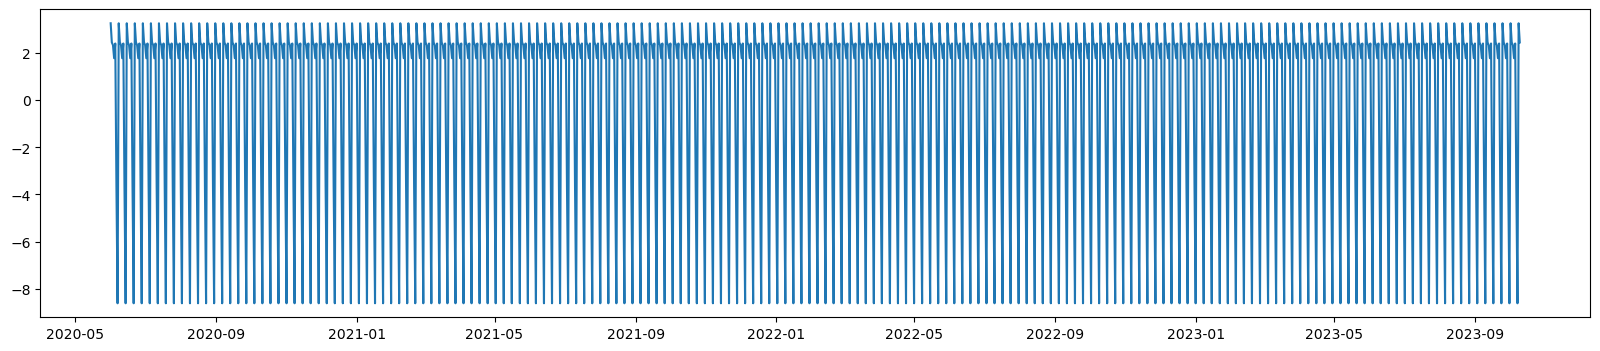

In [7]:
#Extracting weekly seasonality from raw time series
seasonal_7 = sm.tsa.seasonal_decompose(neft_train.Volume, period=7)
plt.figure(figsize=(20,4))
plt.plot(neft_train['Date'], seasonal_7.seasonal)

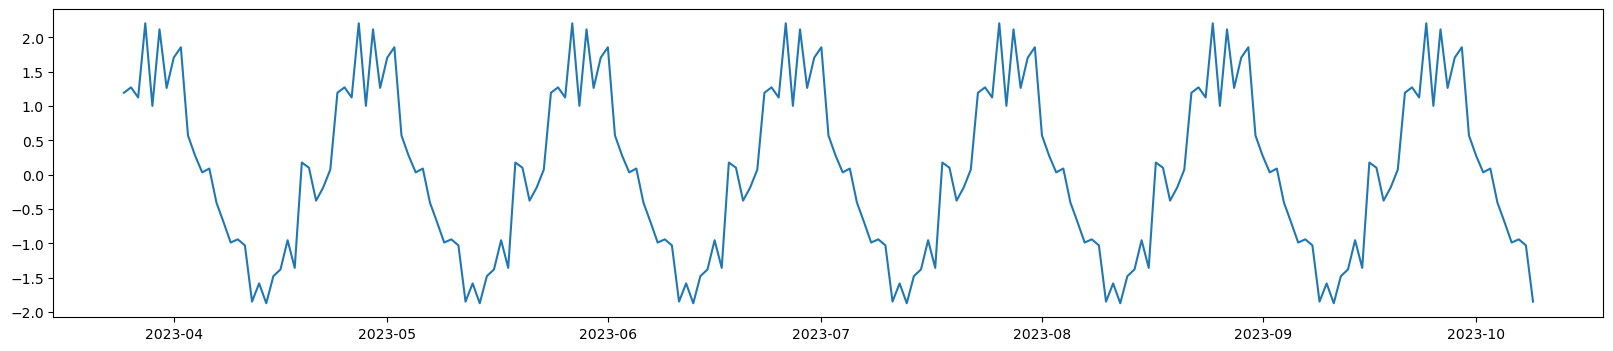

In [8]:
#Extracting monthly seasonality from weekly adjusted series
seasonal_30 = sm.tsa.seasonal_decompose(neft_train.Volume - np.array(seasonal_7.seasonal), period=30)
plt.figure(figsize=(20,4))
plt.plot(neft_train['Date'][-200:-1], seasonal_30.seasonal[-200:-1])

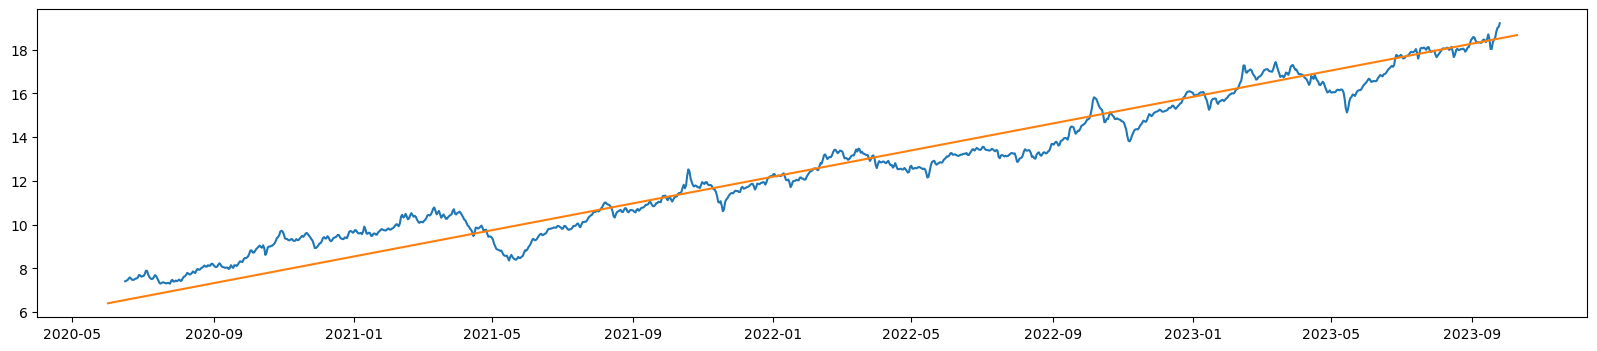

In [9]:
#Trend
plt.figure(figsize=(20,4))
plt.plot(neft_train['Date'], seasonal_30.trend)
plt.plot(neft_train['Date'], 0.01 * neft_train['Date'].index + 6.4)

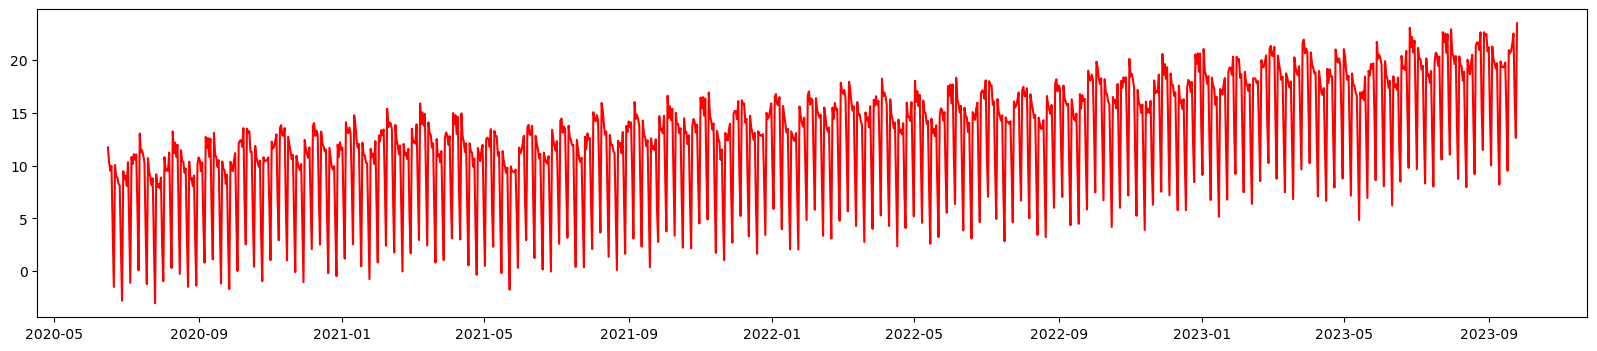

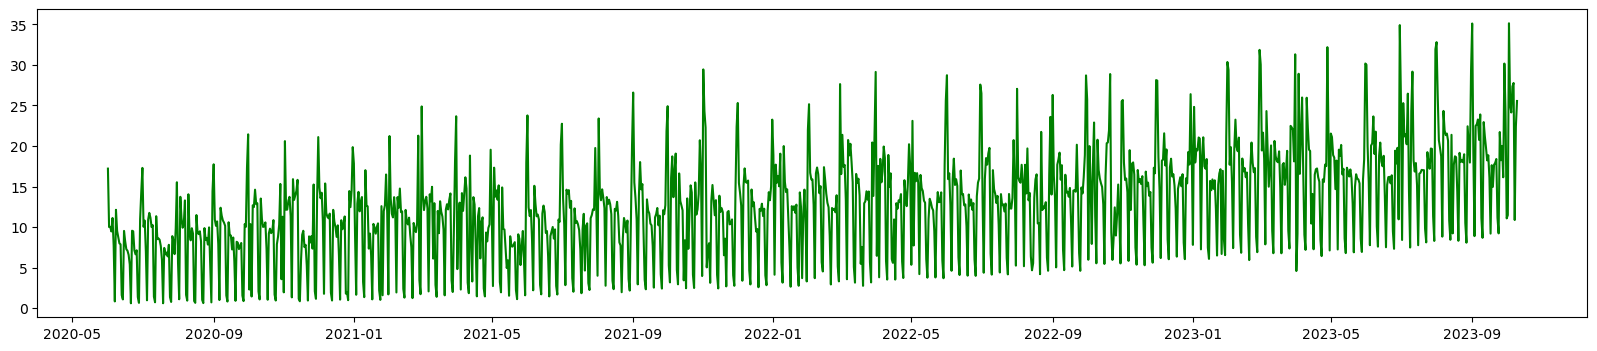

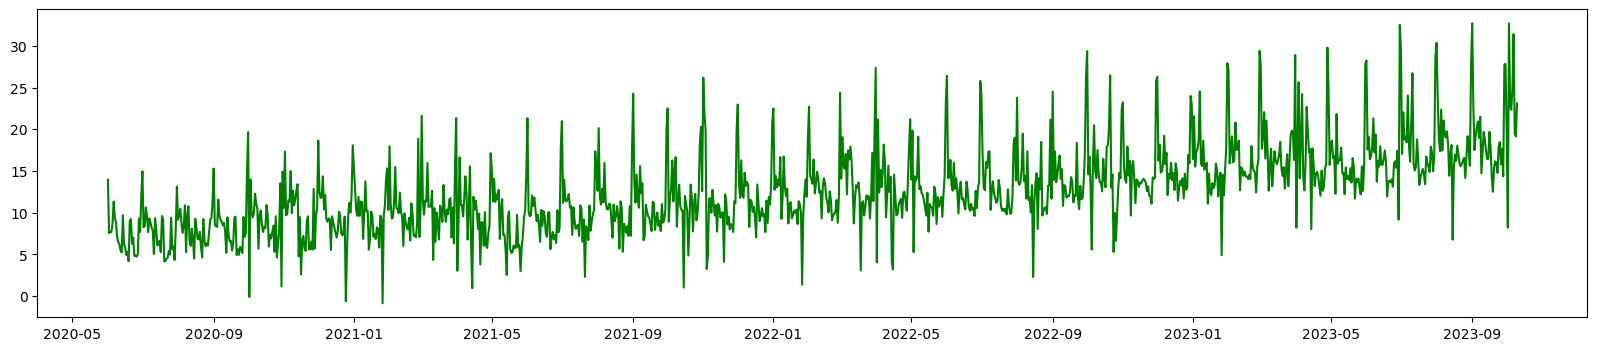

In [10]:
#Model data is the sum of components
modelled_data = seasonal_30.trend + seasonal_30.seasonal + seasonal_7.seasonal
plt.figure(figsize=(20,4))
plt.plot(neft_train['Date'], modelled_data, color = 'red')
plt.figure(figsize=(20,4))
plt.plot(neft_train['Date'], neft_train['Volume'], color = 'green')
plt.figure(figsize=(20,4))
plt.plot(neft_train['Date'], neft_train['Volume'] - seasonal_7.seasonal, color = 'green')

### Separate out the seasonal 7 component and treat the remaining part (Original minus the seaosnal 7 component) with SARIMA

In [11]:
seasonality_30 = neft_train['Volume'] - seasonal_7.seasonal
seasonality_7 = seasonal_7.seasonal

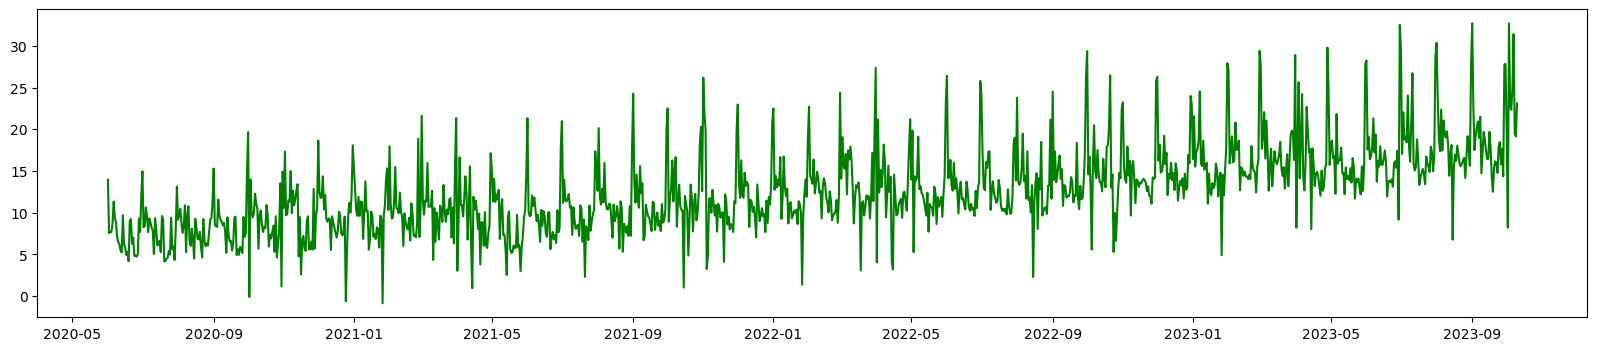

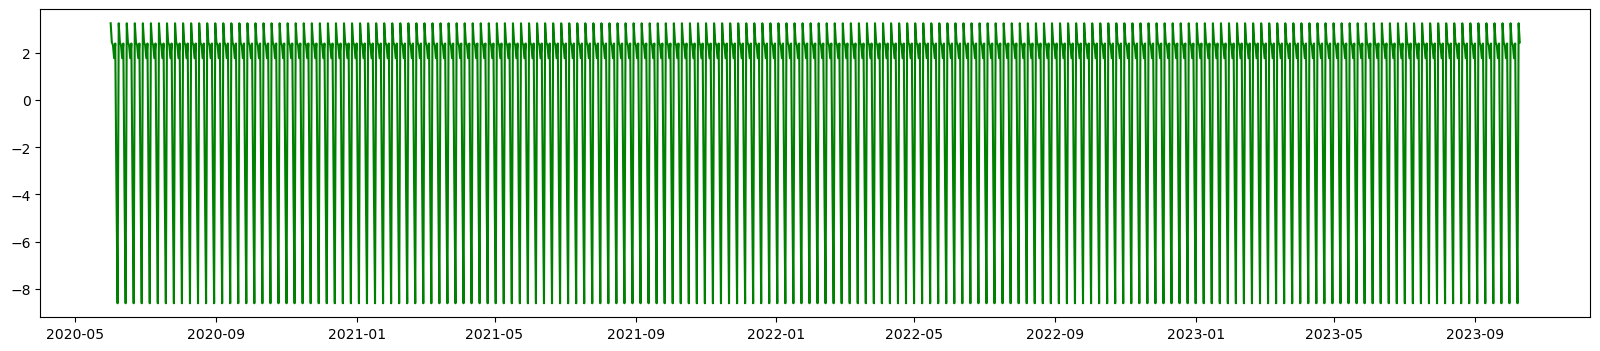

In [12]:
plt.figure(figsize=(20,4))
plt.plot(neft_train['Date'], seasonality_30, color = 'green')

plt.figure(figsize=(20,4))
plt.plot(neft_train['Date'], seasonality_7, color = 'green')

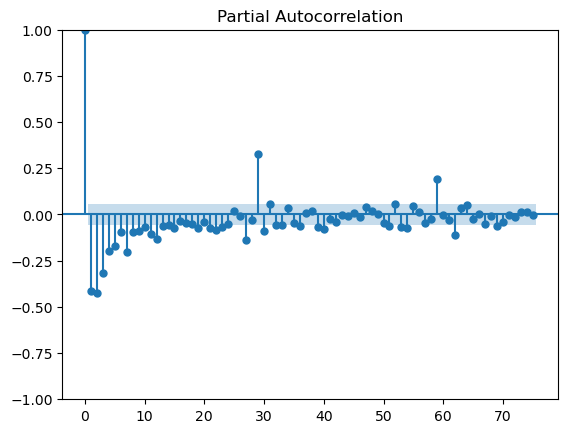

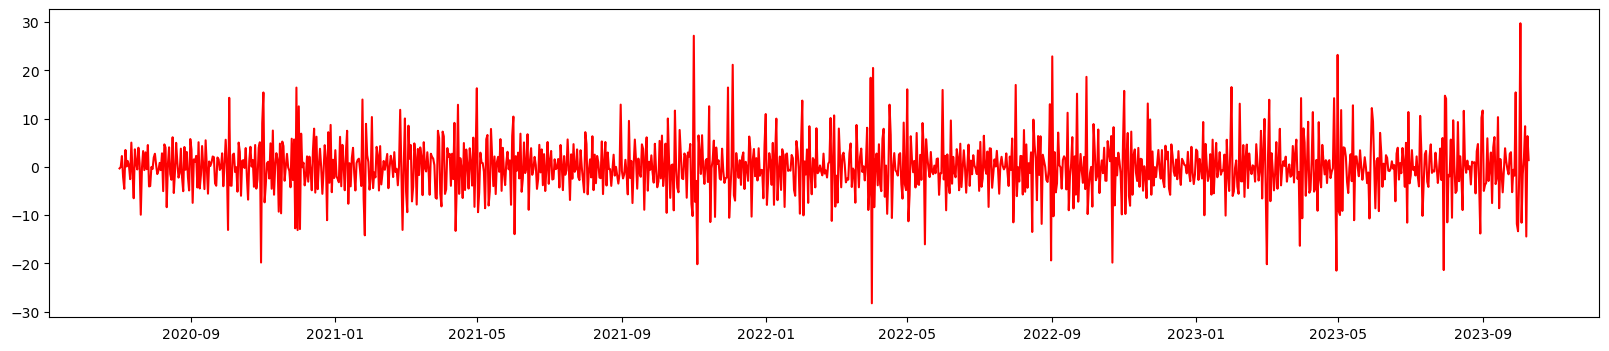

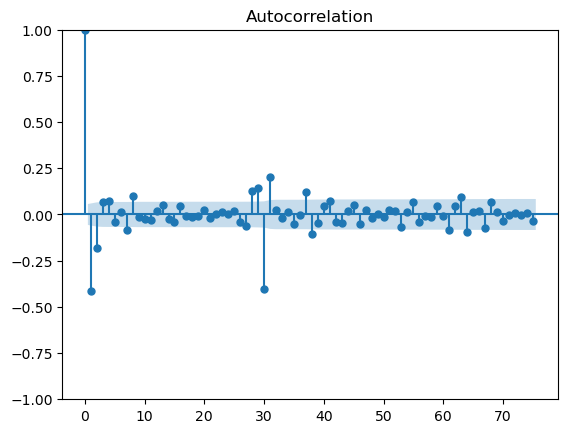

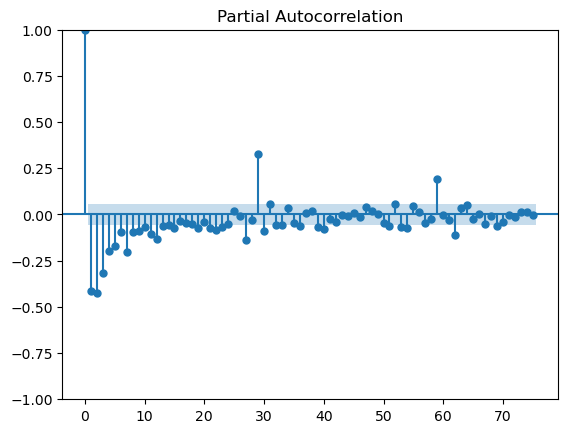

In [13]:
plt.figure(figsize=(20,4))
temp = seasonality_30.diff(1)[1:].diff(30)[30:]
plt.plot(neft_train['Date'][1:][30:], temp, color = 'red')

plot_acf(temp, lags=75)
plot_pacf(temp, lags=75)

A falling PACF combined with an ACF with 2 significant peaks - Indicates a strong presence of a MA(1/2) model.
As we cannot deny the possibility of havign AR tearms, we have considered 0 or 1 AR terms, whcih will be rejected later based on their P-values.
Also, there is a repeating pattern observed in the ACF plot. The pattern repeats at multiples of lag 30 - Which indicates a slight possibility of a seasonal MA1/2 component.
As the repeating pattern in PACF is not that strong, we do not really expect seasonal AR teams to come up.

In [14]:
import itertools

p = list(range(0, 2))
d = list(range(1, 2))
q = list(range(1, 3))
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]
model_evaluation = pd.DataFrame(columns = ['Description', 'AIC'], index = range(0, len(pdq)*len(seasonal_pdq)))
print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
index = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(seasonality_30,
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            model_evaluation.loc[index].Description = "ARIMA{}x{}".format(param, param_seasonal)
            model_evaluation.loc[index].AIC = results.aic
            index += 1
        except Exception as e:
            print("Exception: {}".format(e))
            break

Examples of parameter combinations for Seasonal ARIMA...
ARIMA(0, 1, 1)x(0, 1, 1, 30) - AIC:6234.906257949246
ARIMA(0, 1, 1)x(0, 1, 2, 30) - AIC:6075.99088029413
ARIMA(0, 1, 1)x(1, 1, 1, 30) - AIC:6238.604279470969
ARIMA(0, 1, 1)x(1, 1, 2, 30) - AIC:6077.959620453234
ARIMA(0, 1, 2)x(0, 1, 1, 30) - AIC:6220.685365414802
ARIMA(0, 1, 2)x(0, 1, 2, 30) - AIC:6060.530389762635
ARIMA(0, 1, 2)x(1, 1, 1, 30) - AIC:6223.716144373894
ARIMA(0, 1, 2)x(1, 1, 2, 30) - AIC:6062.51196388194
ARIMA(1, 1, 1)x(0, 1, 1, 30) - AIC:6227.383456944814
ARIMA(1, 1, 1)x(0, 1, 2, 30) - AIC:6068.011734459282
ARIMA(1, 1, 1)x(1, 1, 1, 30) - AIC:6231.238047937947
ARIMA(1, 1, 1)x(1, 1, 2, 30) - AIC:6069.976094243225
ARIMA(1, 1, 2)x(0, 1, 1, 30) - AIC:6216.5394500320335
ARIMA(1, 1, 2)x(0, 1, 2, 30) - AIC:6056.7834042969325
ARIMA(1, 1, 2)x(1, 1, 1, 30) - AIC:6219.169839620269
ARIMA(1, 1, 2)x(1, 1, 2, 30) - AIC:6058.767934263585


In [15]:
model_evaluation.sort_values('AIC')

,Description,AIC
13,"ARIMA(1, 1, 2)x(0, 1, 2, 30)",6056.783404
15,"ARIMA(1, 1, 2)x(1, 1, 2, 30)",6058.767934
5,"ARIMA(0, 1, 2)x(0, 1, 2, 30)",6060.53039
7,"ARIMA(0, 1, 2)x(1, 1, 2, 30)",6062.511964
9,"ARIMA(1, 1, 1)x(0, 1, 2, 30)",6068.011734
11,"ARIMA(1, 1, 1)x(1, 1, 2, 30)",6069.976094
1,"ARIMA(0, 1, 1)x(0, 1, 2, 30)",6075.99088
3,"ARIMA(0, 1, 1)x(1, 1, 2, 30)",6077.95962
12,"ARIMA(1, 1, 2)x(0, 1, 1, 30)",6216.53945
14,"ARIMA(1, 1, 2)x(1, 1, 1, 30)",6219.16984


In [16]:
#Model choosen after considering the p-values of the coefficients
mod = sm.tsa.statespace.SARIMAX(neft_train['Volume'],
            order=[0, 1, 1],
            seasonal_order=[0, 1, 2, 30],
            enforce_stationarity=False,
            enforce_invertibility=False)
results = mod.fit()

print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                  Volume   No. Observations:                 1227
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 30)   Log Likelihood               -3586.378
Date:                                 Wed, 13 Dec 2023   AIC                           7180.756
Time:                                         00:41:17   BIC                           7200.890
Sample:                                              0   HQIC                          7188.362
                                                - 1227                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9960      0.005   -193.403      0.000      -1.006      -0

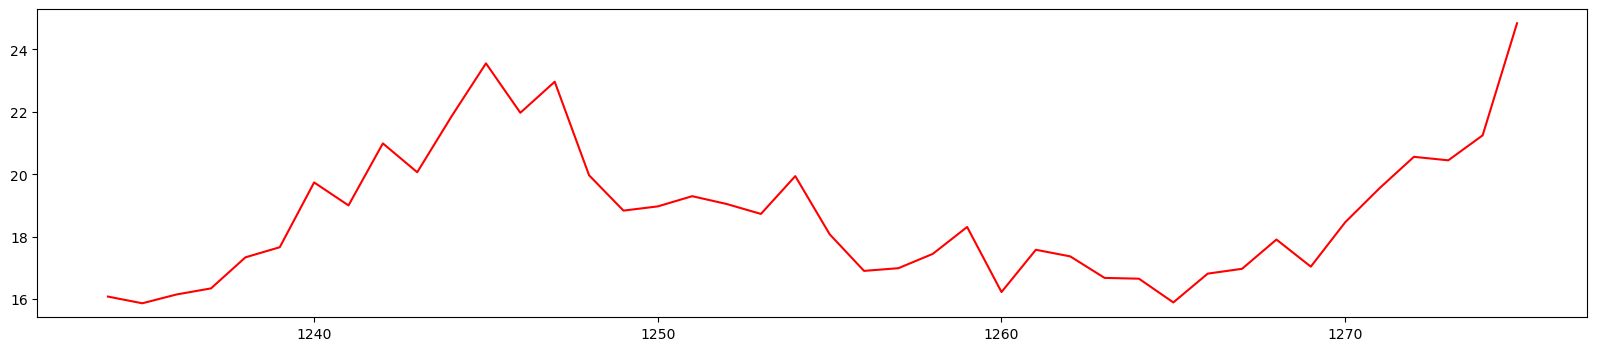

In [17]:
plt.figure(figsize=(20,4))
temp_7 = seasonality_7
plt.plot(results.predict(start = 1234, end = 1275), color = 'red')

MAE: 4.67
MSE: 34.84
RMSE: 5.90
MAPE: 22.35%
sMAPE: 25.91%


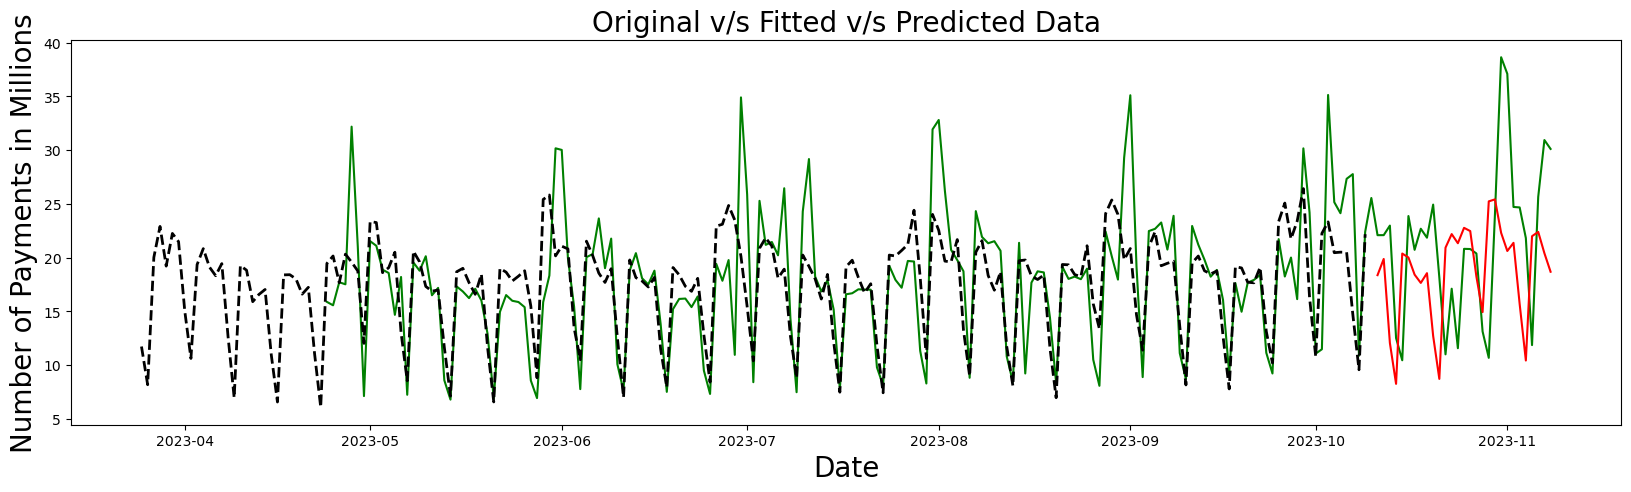

In [18]:
predictions = results.predict(start = 1228, end = 1275)
full_prediction = results.predict() + temp_7
plt.figure(figsize=(20,5))


plt.title("Original v/s Fitted v/s Predicted Data", fontsize=20)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Number of Payments in Millions", fontsize=20)
plt.plot(neft_data['Date'][-200:-1], neft_data['Volume'][-200:-1], color='green')

plt.plot(neft_test['Date'][:29], predictions[:29].values + temp_7[10:39].values, color='red')

plt.plot(neft_train['Date'][-200:-1], full_prediction[-200:-1], color='black', linestyle='dashed', linewidth=2)

# Calculate errors
errors = neft_test.Volume - (predictions[:29]+temp_7[10:39].values)
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(errors / neft_test.Volume)) * 100
smape = np.mean(2 * np.abs(errors) / (np.abs(neft_test.Volume) + np.abs(predictions[10:39]+temp_7[10:39].values))) * 100

# Print results
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'sMAPE: {smape:.2f}%')

In [19]:
residual_custom = neft_train.Volume - full_prediction

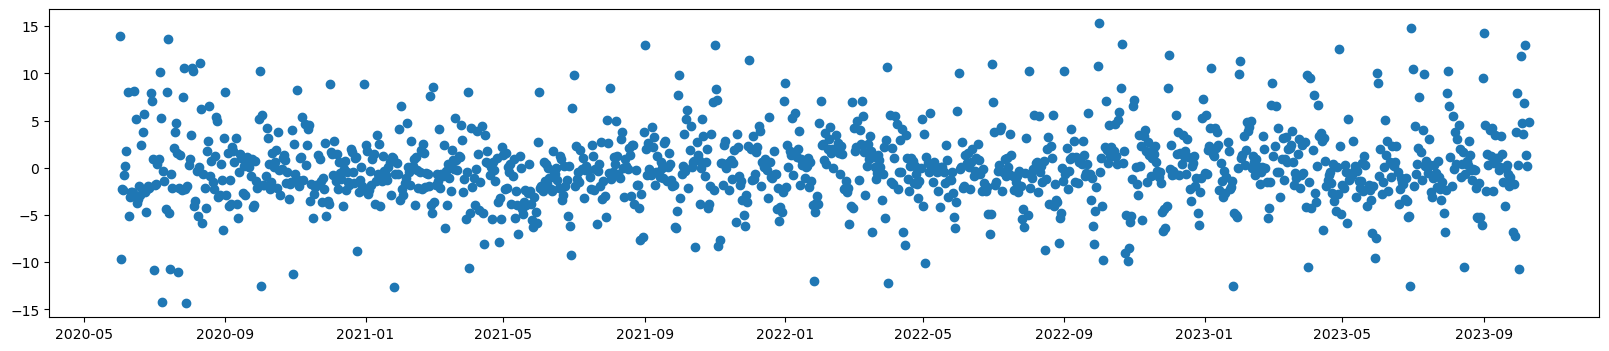

In [20]:
plt.figure(figsize=(20,4))
plt.scatter(neft_train.Date, residual_custom)

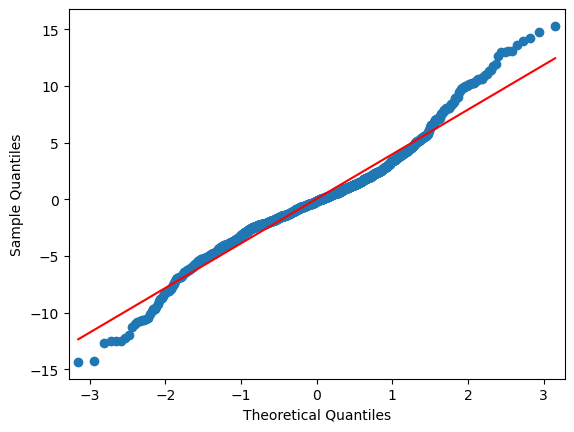

In [21]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(residual_custom, line='r')
plt.show()

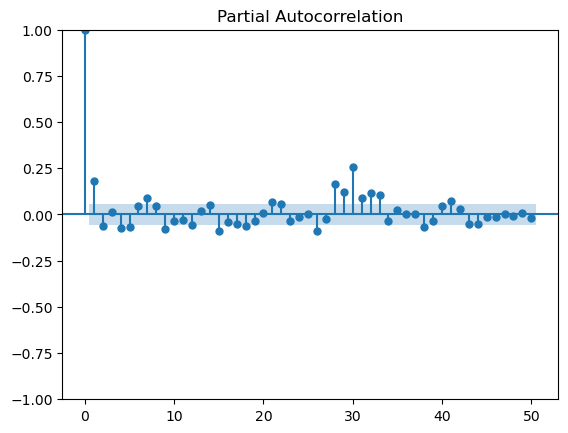

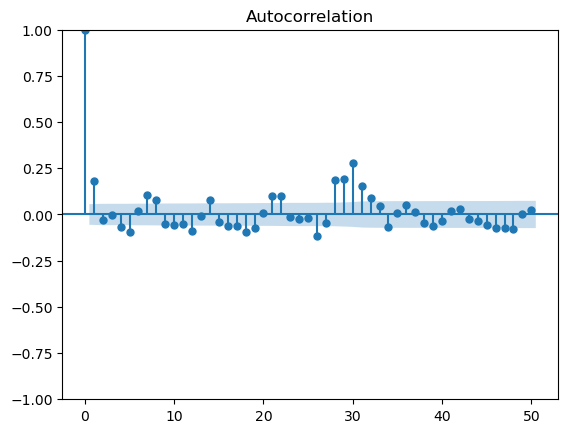

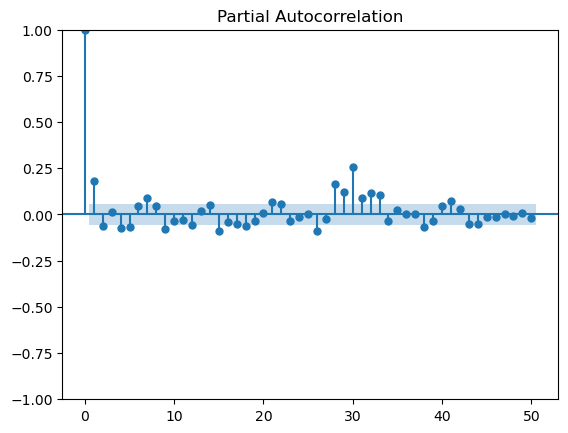

In [22]:
plot_acf(residual_custom, lags=50)
plot_pacf(residual_custom, lags=50)

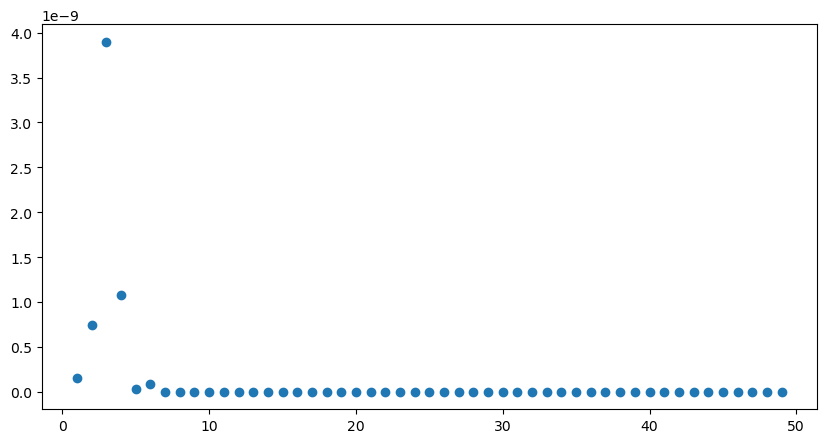

In [23]:
plt.figure(figsize = (10, 5))
plt.scatter(range(0, 50), sm.stats.acorr_ljungbox(residual_custom, lags=range(0, 50), return_df=True).lb_pvalue)

### Separate out the seasonal 30 component and treat the remaining part (Original minus the seaosnal 30 component) with SARIMA

In [24]:
seasonality_7 = neft_train['Volume'] - seasonal_30.seasonal
seasonality_30 = seasonal_30.seasonal

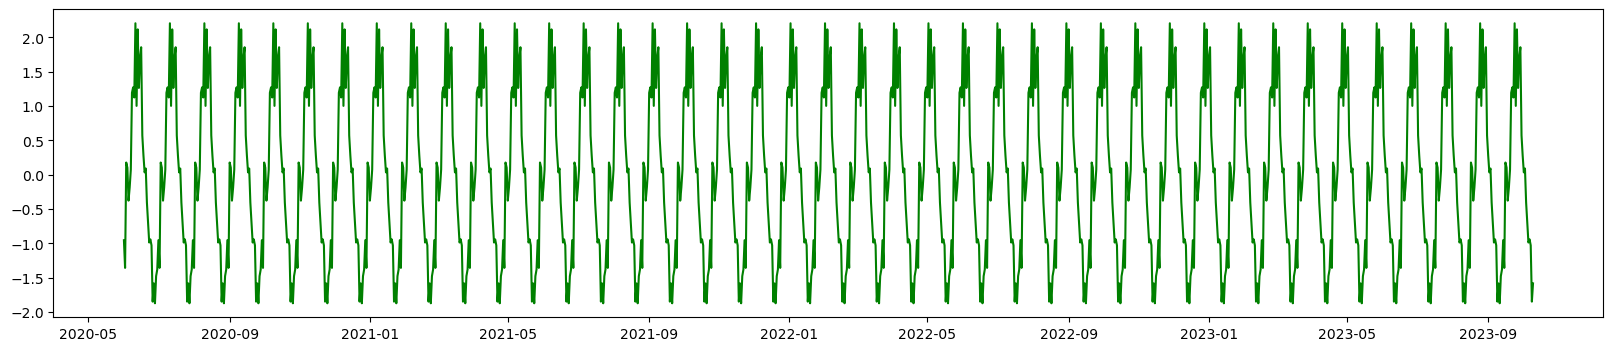

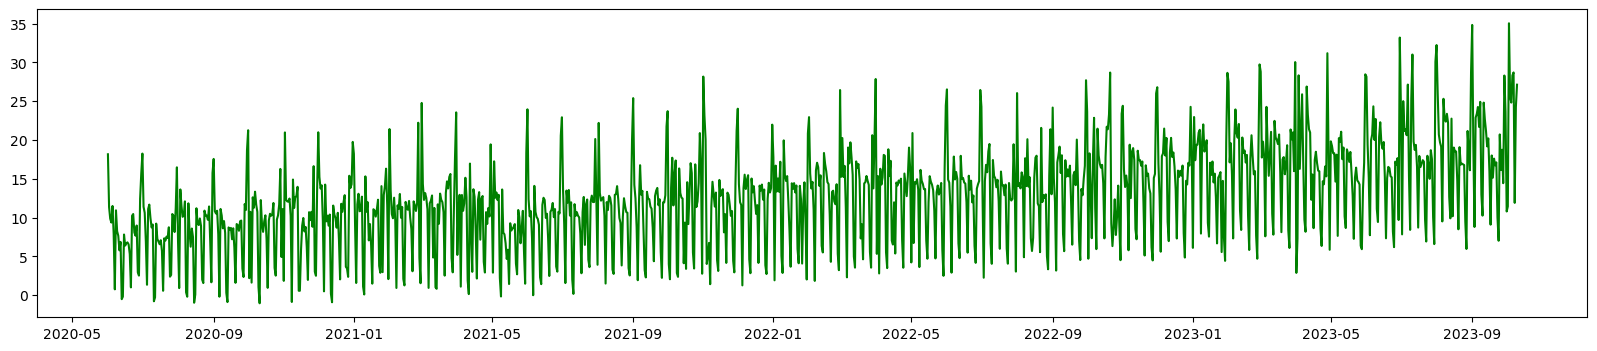

In [25]:
plt.figure(figsize=(20,4))
plt.plot(neft_train['Date'], seasonality_30, color = 'green')

plt.figure(figsize=(20,4))
plt.plot(neft_train['Date'], seasonality_7, color = 'green')

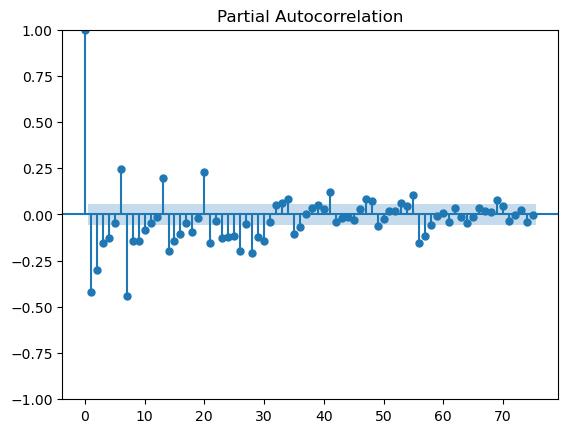

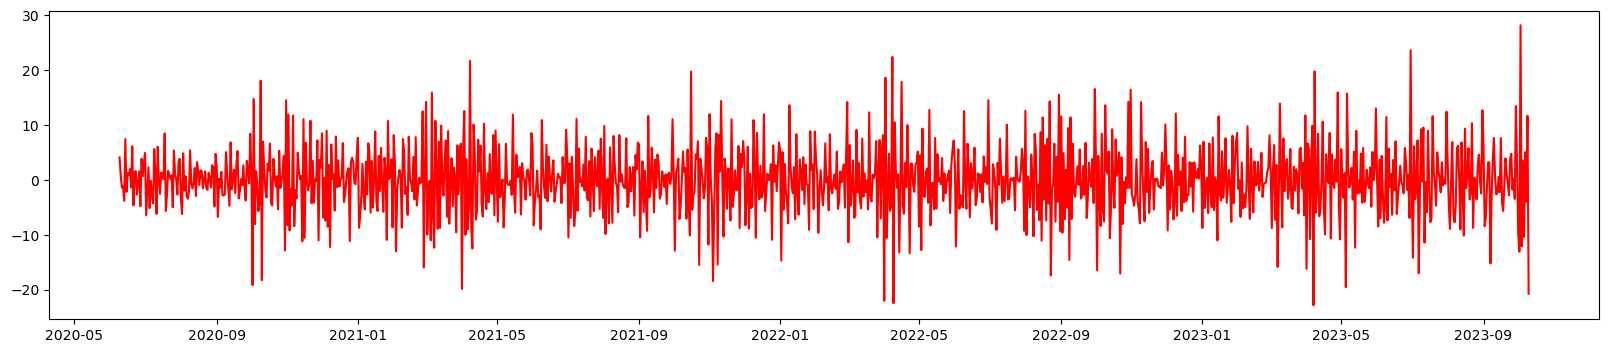

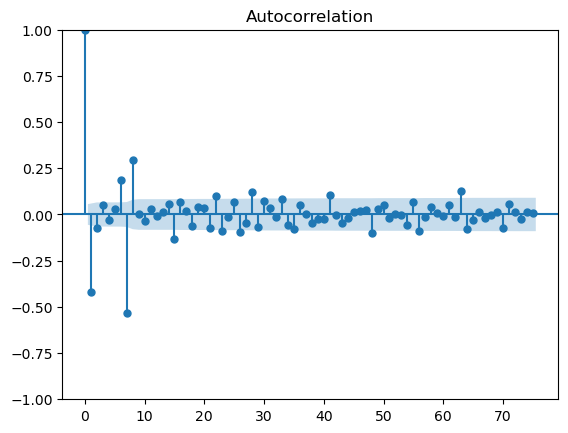

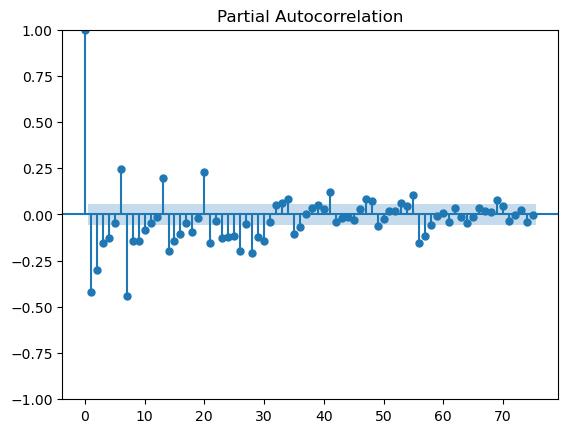

In [26]:
plt.figure(figsize=(20,4))
temp = seasonality_7.diff(1)[1:].diff(7)[7:]
plt.plot(neft_train['Date'][1:][7:], temp, color = 'red')

plot_acf(temp, lags=75)
plot_pacf(temp, lags=75)

In [27]:
import itertools

p = list(range(0, 2))
d = list(range(1, 2))
q = list(range(0, 2))
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
model_evaluation = pd.DataFrame(columns = ['Description', 'AIC'], index = range(0, len(pdq)*len(seasonal_pdq)))
print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
index = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(seasonality_30,
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            model_evaluation.loc[index].Description = "ARIMA{}x{}".format(param, param_seasonal)
            model_evaluation.loc[index].AIC = results.aic
            index += 1
        except Exception as e:
            print("Exception: {}".format(e))
            break

Examples of parameter combinations for Seasonal ARIMA...
ARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC:3128.4941117023523
ARIMA(0, 1, 0)x(0, 1, 1, 7) - AIC:2401.074956916391
ARIMA(0, 1, 0)x(1, 1, 0, 7) - AIC:2829.414422579046


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 1, 1, 7) - AIC:2400.306635428638
ARIMA(0, 1, 1)x(0, 1, 0, 7) - AIC:3030.816826004969
ARIMA(0, 1, 1)x(0, 1, 1, 7) - AIC:2282.058596783916
ARIMA(0, 1, 1)x(1, 1, 0, 7) - AIC:2807.179377883912
ARIMA(0, 1, 1)x(1, 1, 1, 7) - AIC:2286.139278048114
ARIMA(1, 1, 0)x(0, 1, 0, 7) - AIC:3014.8127184721143
ARIMA(1, 1, 0)x(0, 1, 1, 7) - AIC:2237.8260225602826
ARIMA(1, 1, 0)x(1, 1, 0, 7) - AIC:2795.487124899989
ARIMA(1, 1, 0)x(1, 1, 1, 7) - AIC:2238.267518987377
ARIMA(1, 1, 1)x(0, 1, 0, 7) - AIC:3011.087639522409
ARIMA(1, 1, 1)x(0, 1, 1, 7) - AIC:2222.0498656160494
ARIMA(1, 1, 1)x(1, 1, 0, 7) - AIC:2789.601860743437
ARIMA(1, 1, 1)x(1, 1, 1, 7) - AIC:2223.593869677826


In [28]:
model_evaluation.sort_values('AIC')

,Description,AIC
13,"ARIMA(1, 1, 1)x(0, 1, 1, 7)",2222.049866
15,"ARIMA(1, 1, 1)x(1, 1, 1, 7)",2223.59387
9,"ARIMA(1, 1, 0)x(0, 1, 1, 7)",2237.826023
11,"ARIMA(1, 1, 0)x(1, 1, 1, 7)",2238.267519
5,"ARIMA(0, 1, 1)x(0, 1, 1, 7)",2282.058597
7,"ARIMA(0, 1, 1)x(1, 1, 1, 7)",2286.139278
3,"ARIMA(0, 1, 0)x(1, 1, 1, 7)",2400.306635
1,"ARIMA(0, 1, 0)x(0, 1, 1, 7)",2401.074957
14,"ARIMA(1, 1, 1)x(1, 1, 0, 7)",2789.601861
10,"ARIMA(1, 1, 0)x(1, 1, 0, 7)",2795.487125


In [29]:
mod = sm.tsa.statespace.SARIMAX(neft_train['Volume'],
            order=[1, 1, 1],
            seasonal_order=[0, 1, 1, 7],
            enforce_stationarity=False,
            enforce_invertibility=False)
results = mod.fit()

print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Volume   No. Observations:                 1227
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -3279.154
Date:                           Wed, 13 Dec 2023   AIC                           6566.309
Time:                                   00:42:15   BIC                           6586.702
Sample:                                        0   HQIC                          6573.988
                                          - 1227                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3375      0.020     17.275      0.000       0.299       0.376
ma.L1         -1.0049      0.006   -159.305

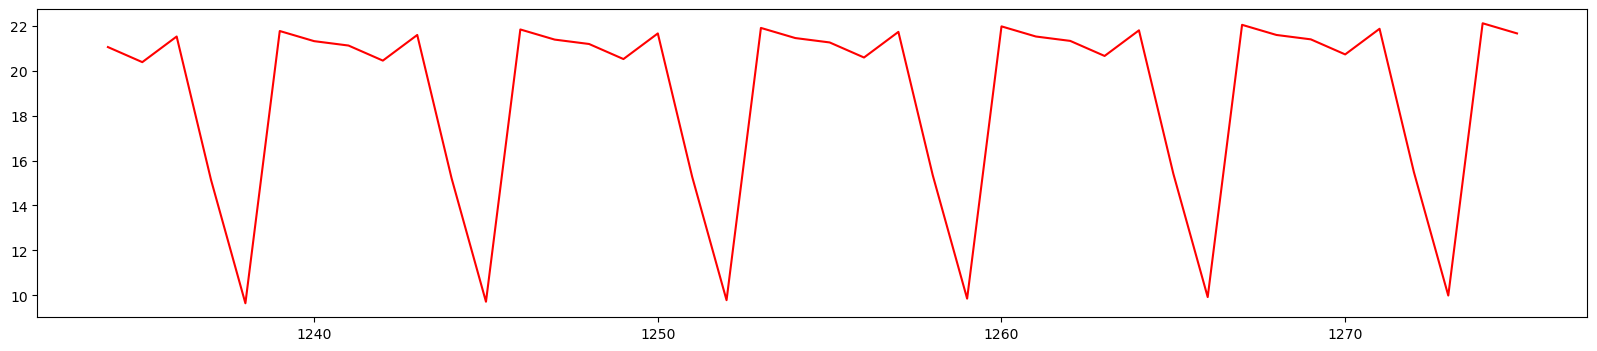

In [30]:
plt.figure(figsize=(20,4))
temp_30 = seasonality_30
plt.plot(results.predict(start = 1234, end = 1275), color = 'red')

MAE: 4.32
MSE: 35.41
RMSE: 5.95
MAPE: 19.73%
sMAPE: 20.35%


<Figure size 2000x500 with 0 Axes>

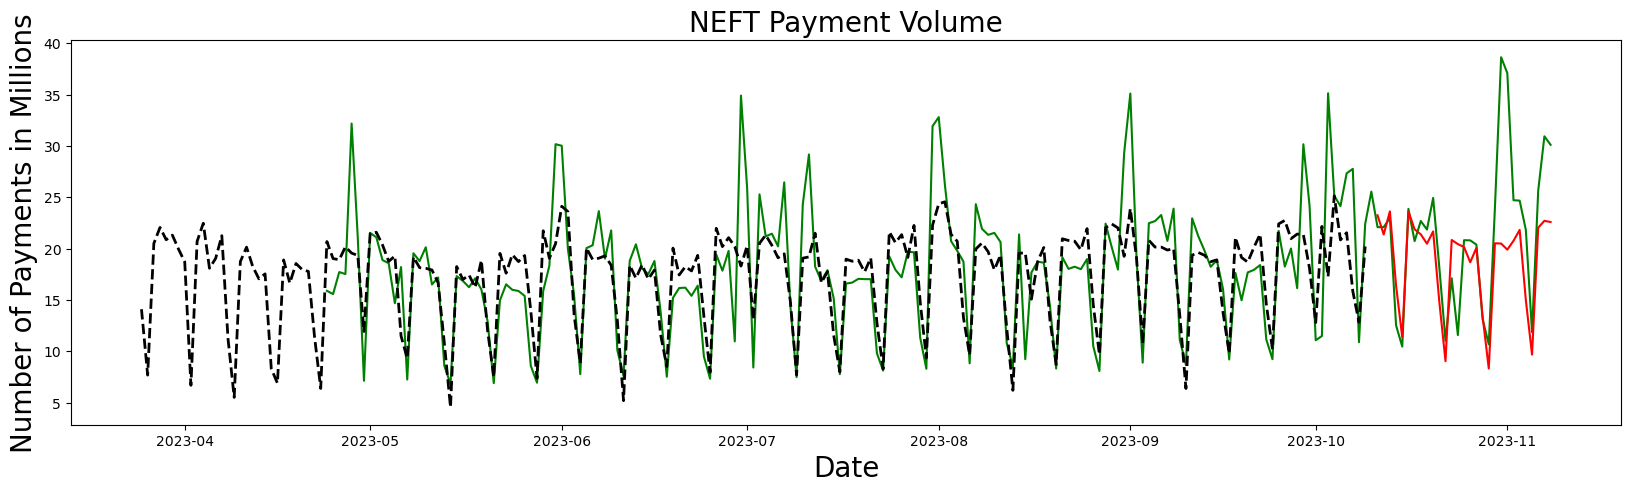

In [32]:
predictions = results.predict(start = 1234, end = 1275)
full_prediction = results.predict() + temp_30
plt.figure(figsize=(20,5))
#Plot Entire Graph
plt.figure(figsize=(20,5))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Number of Payments in Millions', fontsize=20)
plt.title('NEFT Payment Volume', fontsize=20)


plt.plot(neft_data['Date'][-200:-1], neft_data['Volume'][-200:-1], color='green')

plt.plot(neft_test['Date'][:29], predictions[:29].values + temp_30[10:39].values, color='red')

plt.plot(neft_train['Date'][-200:-1], full_prediction[-200:-1], color='black', linestyle='dashed', linewidth=2)

# Calculate errors
errors = neft_test.Volume - predictions[:29].values + temp_30[10:39].values
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(errors / neft_test.Volume)) * 100
smape = np.mean(2 * np.abs(errors) / (np.abs(neft_test.Volume) + np.abs(predictions[:29].values + temp_30[10:39].values))) * 100

# Print results
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'sMAPE: {smape:.2f}%')

In [33]:
residual_custom = neft_train.Volume - full_prediction

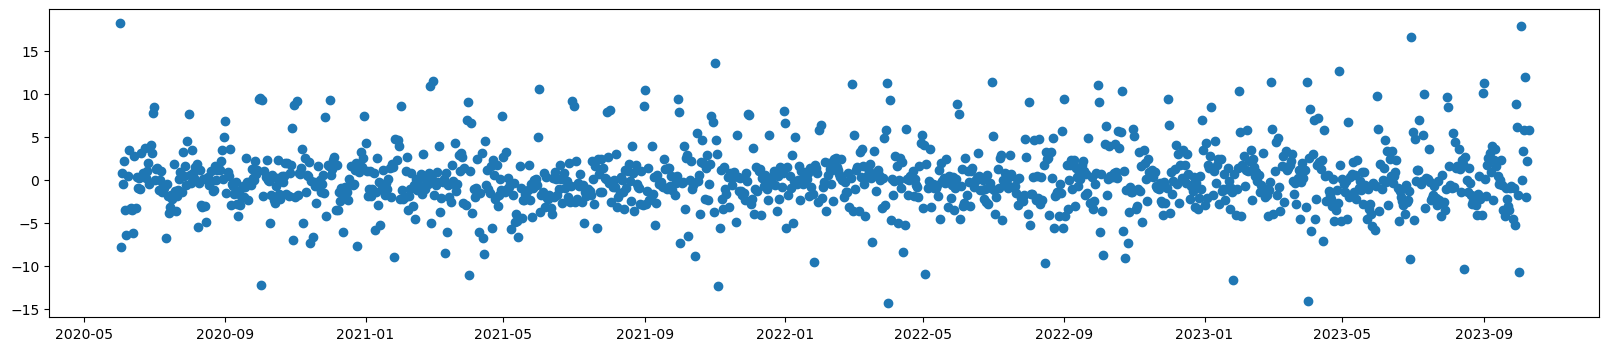

In [34]:
plt.figure(figsize=(20,4))
plt.scatter(neft_train.Date, residual_custom)

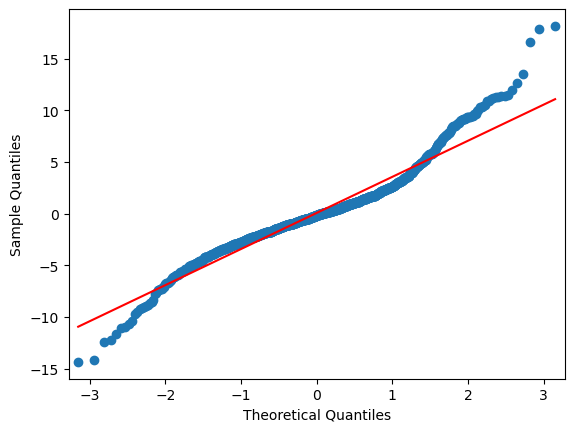

In [35]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(residual_custom, line='r')
plt.show()

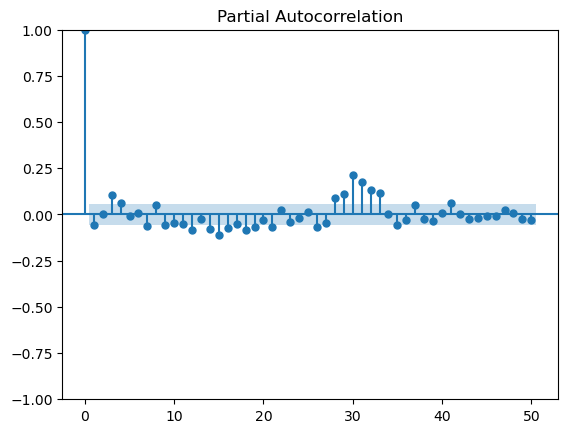

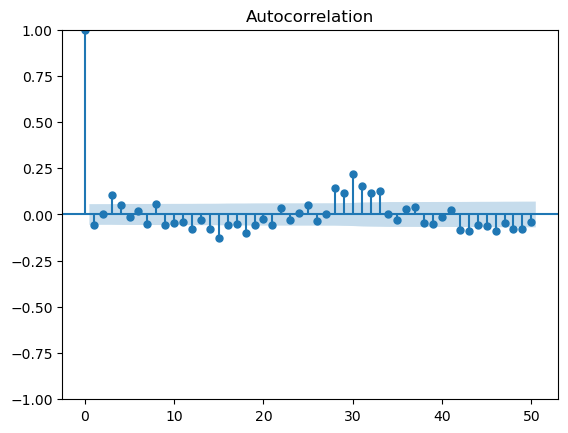

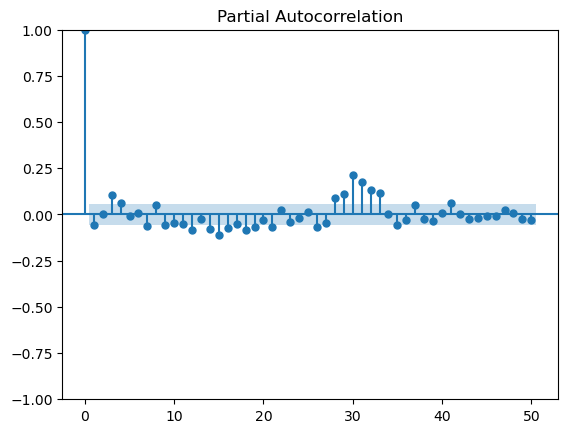

In [36]:
plot_acf(residual_custom, lags=50)
plot_pacf(residual_custom, lags=50)

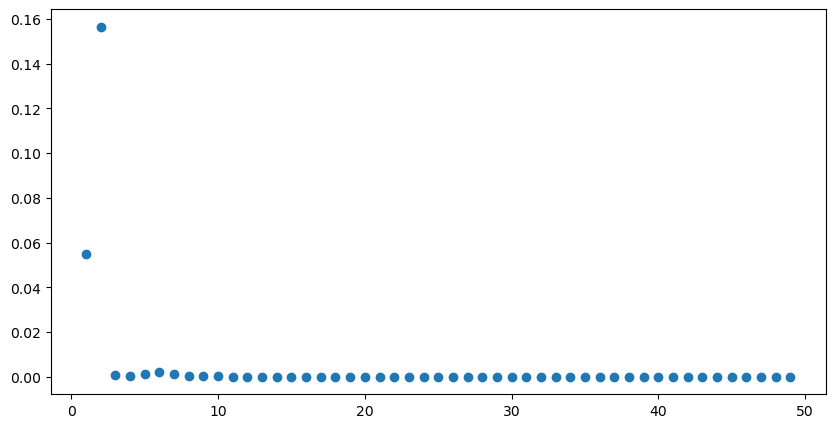

In [37]:
plt.figure(figsize = (10, 5))
plt.scatter(range(0, 50), sm.stats.acorr_ljungbox(residual_custom, lags=range(0, 50), return_df=True).lb_pvalue)